<a href="https://colab.research.google.com/github/berfiniremm/U-Net-Lung-SegmentationS/blob/main/staj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
IMAGE_DIR = "/content/drive/MyDrive/Berf/image"
MASK_DIR  = "/content/drive/MyDrive/Berf/mask"


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os


In [4]:
class MedicalDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()
        return image, mask


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = MedicalDataset(IMAGE_DIR, MASK_DIR, transform=transform)

# %80 train - %20 test böl
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Toplam veri:", len(dataset))
print("Eğitim verisi:", len(train_dataset))
print("Test verisi:", len(test_dataset))


Toplam veri: 6810
Eğitim verisi: 5448
Test verisi: 1362


In [6]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.middle = DoubleConv(512, 1024)

        self.up4 = DoubleConv(1024 + 512, 512)
        self.up3 = DoubleConv(512 + 256, 256)
        self.up2 = DoubleConv(256 + 128, 128)
        self.up1 = DoubleConv(128 + 64, 64)
        self.final = nn.Conv2d(64, out_channels, 1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.pool(c1))
        c3 = self.down3(self.pool(c2))
        c4 = self.down4(self.pool(c3))
        m = self.middle(self.pool(c4))

        up4 = torch.cat([F.interpolate(m, scale_factor=2, mode='bilinear', align_corners=True), c4], dim=1)
        up4 = self.up4(up4)
        up3 = torch.cat([F.interpolate(up4, scale_factor=2, mode='bilinear', align_corners=True), c3], dim=1)
        up3 = self.up3(up3)
        up2 = torch.cat([F.interpolate(up3, scale_factor=2, mode='bilinear', align_corners=True), c2], dim=1)
        up2 = self.up2(up2)
        up1 = torch.cat([F.interpolate(up2, scale_factor=2, mode='bilinear', align_corners=True), c1], dim=1)
        up1 = self.up1(up1)

        return torch.sigmoid(self.final(up1))


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [8]:
from tqdm import tqdm

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Ortalama Loss: {epoch_loss/len(train_loader):.4f}")

print("✅ Eğitim tamamlandı.")


100%|██████████| 1362/1362 [1:14:43<00:00,  3.29s/it]


Epoch [1/10] - Ortalama Loss: 0.1570


100%|██████████| 1362/1362 [07:16<00:00,  3.12it/s]


Epoch [2/10] - Ortalama Loss: 0.0877


100%|██████████| 1362/1362 [07:18<00:00,  3.10it/s]


Epoch [3/10] - Ortalama Loss: 0.0773


100%|██████████| 1362/1362 [07:18<00:00,  3.11it/s]


Epoch [4/10] - Ortalama Loss: 0.0735


100%|██████████| 1362/1362 [07:18<00:00,  3.11it/s]


Epoch [5/10] - Ortalama Loss: 0.0707


100%|██████████| 1362/1362 [07:18<00:00,  3.11it/s]


Epoch [6/10] - Ortalama Loss: 0.0683


100%|██████████| 1362/1362 [07:18<00:00,  3.11it/s]


Epoch [7/10] - Ortalama Loss: 0.0657


100%|██████████| 1362/1362 [07:18<00:00,  3.11it/s]


Epoch [8/10] - Ortalama Loss: 0.0640


100%|██████████| 1362/1362 [07:20<00:00,  3.09it/s]


Epoch [9/10] - Ortalama Loss: 0.0632


100%|██████████| 1362/1362 [07:21<00:00,  3.09it/s]

Epoch [10/10] - Ortalama Loss: 0.0613
✅ Eğitim tamamlandı.


✅ Test Dice Score (Ortalama): 0.9456


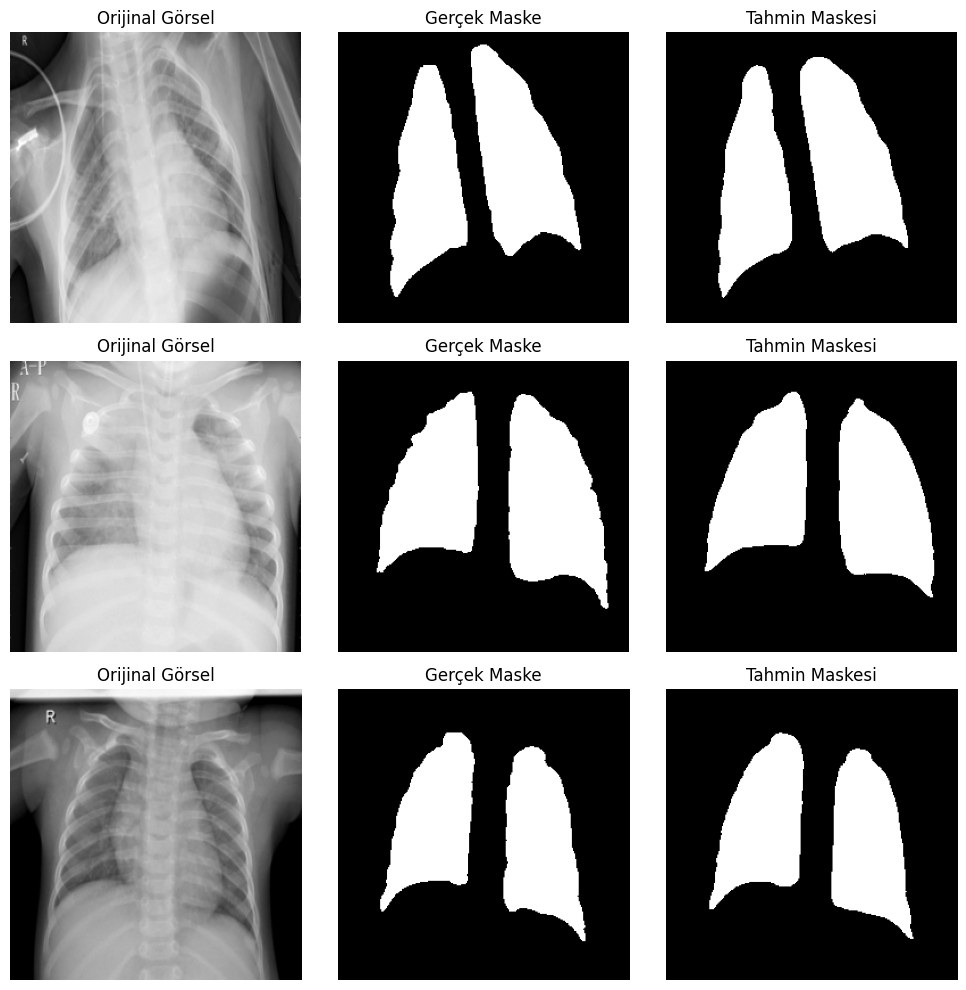

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()
dice_scores = []
example_images = []

with torch.no_grad():
    for i, (imgs, masks) in enumerate(test_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        preds_bin = (preds > 0.5).float()

        # Dice Score
        intersection = (preds_bin * masks).sum()
        dice = (2 * intersection) / (preds_bin.sum() + masks.sum() + 1e-8)
        dice_scores.append(dice.item())

        # İlk 3 örneği kaydedelim
        if i < 3:
            example_images.append((imgs[0].cpu(), masks[0].cpu(), preds_bin[0].cpu()))

print(f"✅ Test Dice Score (Ortalama): {np.mean(dice_scores):.4f}")

# Görselleştirme
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for i, (img, mask, pred) in enumerate(example_images):
    axes[i,0].imshow(img.squeeze(), cmap='gray'); axes[i,0].set_title("Orijinal Görsel")
    axes[i,1].imshow(mask.squeeze(), cmap='gray'); axes[i,1].set_title("Gerçek Maske")
    axes[i,2].imshow(pred.squeeze(), cmap='gray'); axes[i,2].set_title("Tahmin Maskesi")

for ax in axes.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()
